6.) Siéntate recto
==
Miquel Gotanegra



El tener una buena postura al sentarse evita muchos problemas de salud. A medida que nos
hacemos mayores van apareciendo diversos problemas de espalda que han de diagnosticarse.
El conjunto de datos Vertebral Column Data Set7 del repositorio de conjuntos de datos de UCI
recoge medidas tomadas de la forma y orientación de la pelvis y la parte lumbar de la columna
vertebral para un conjunto de pacientes sin problemas y con dos diferentes diagnósticos (hernia
discal y Spondylolisthesis). El objetivo es obtener un modelo que pueda distinguir los pacientes
sin problemas y los dos diagnósticos.
En este conjunto de datos hay algo de desbalance entre las clases. La mayoría de los métodos
de scikit-learn tienen un parámetro class_weight que permite darle el peso a las clases. Usa
el valor "balanced" (se le da un peso a las clases de manera que parezca que tienen el mismo
número de ejemplos) a la hora de ajustar los modelos que lo permitan.
Puedes obtener estos datos mediante la función load_column de la librería apafib. Resuelve
los siguientes apartados ilustrando los resultados de la manera que te parezca adecuada.


In [105]:
# Uncomment to upgrade packages
# !pip install pandas --user --upgrade --quiet
# !pip install numpy==1.23.5 --user --upgrade --quiet
# !pip install scipy --user --upgrade --quiet
# !pip install statsmodels --user --upgrade --quiet
# !pip install seaborn --user --upgrade --quiet
# !pip install matplotlib --user --upgrade --quiet
# !pip install scikit-learn --user --upgrade 
# !pip install imblearn --upgrade --user --quiet
# !pip install scikit-optimize --user --quiet
# !pip install dtreeviz==1.4.1 --user --upgrade  --quiet
# !pip install yellowbrick --upgrade --user --quiet
# !pip install apafib --upgrade --user --quiet
# !pip install eli5 --upgrade --user --quiet

In [106]:
import pandas as pd
from pandas import read_csv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                     f1_score, make_scorer, accuracy_score, roc_auc_score

from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier,ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB
from sklearn.ensemble import StackingClassifier, VotingClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier.rocauc import roc_auc
from skopt import BayesSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import  RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import  ConfusionMatrixDisplay,\
                    classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import LinearSVC, SVC
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier,ExtraTreesClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.ensemble import StackingClassifier, VotingClassifier

import eli5
from dtreeviz.trees import dtreeviz

import warnings
from apafib import load_attrition

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
# sns.set()
pd.set_option('display.precision', 3)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from collections import Counter

def save_results(clf, X_test, y_test, nclf, df):
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (W)'] = precision_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'recall score (W)'] = recall_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='weighted')
    return df

results_df = pd.DataFrame()

In [107]:
def save_results(clf, X_test, y_test, nclf, df):
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (W)'] = precision_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'recall score (W)'] = recall_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='weighted')
    return df

results_df = pd.DataFrame()

niter = 15
cv = 5

In [108]:
from apafib import load_column

<strong>
a) Divide el conjunto de datos en entrenamiento y test (70 %/30 %). Transforma las variables
adecuadamente para poder ajustar un modelo de clasificación tanto el conjunto de entrenamiento como el de test. Para poder comparar la eficacia de los métodos estableceremos
la regresión logística como modelo base. Ajusta los hiperparámetros de este modelo adecuadamente y evalúa su calidad.


In [109]:
df = load_column()
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.03,22.55,39.61,40.48,98.67,-0.25,DH
1,39.06,10.06,25.02,29.00,114.41,4.56,DH
2,68.83,22.22,50.09,46.61,105.99,-3.53,DH
3,69.30,24.65,44.31,44.64,101.87,11.21,DH
4,49.71,9.65,28.32,40.06,108.17,7.92,DH


In [110]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
pelvic_incidence,310.0,NaN,NaN,NaN,60.496,17.236,26.15,46.432,58.69,72.88,129.83
pelvic_tilt,310.0,NaN,NaN,NaN,17.543,10.008,-6.55,10.668,16.36,22.12,49.43
lumbar_lordosis_angle,310.0,NaN,NaN,NaN,51.931,18.554,14.0,37.0,49.565,63.0,125.74
sacral_slope,310.0,NaN,NaN,NaN,42.954,13.423,13.37,33.348,42.405,52.693,121.43
pelvic_radius,310.0,NaN,NaN,NaN,117.921,13.318,70.08,110.71,118.265,125.468,163.07
degree_spondylolisthesis,310.0,NaN,NaN,NaN,26.297,37.559,-11.06,1.6,11.765,41.285,418.54
class,310,3,SL,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
print(df.to_string())

     pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  pelvic_radius  degree_spondylolisthesis class
0               63.03        22.55                  39.61         40.48          98.67                     -0.25    DH
1               39.06        10.06                  25.02         29.00         114.41                      4.56    DH
2               68.83        22.22                  50.09         46.61         105.99                     -3.53    DH
3               69.30        24.65                  44.31         44.64         101.87                     11.21    DH
4               49.71         9.65                  28.32         40.06         108.17                      7.92    DH
5               40.25        13.92                  25.12         26.33         130.33                      2.23    DH
6               53.43        15.86                  37.17         37.57         120.57                      5.99    DH
7               45.37        10.76              

Haciendo una pequeña exploración superficial de los datos podemos observar que el grado degree_spondylolisthesis esta fuertemente relacionado con la classe SL, todas las personas con degree > 20 tienen SL. Aún asi, en las regiones por debajo de 20 encontramos personas dentro de las tres classes, asi que creo que es combeniente  dejar este atributo aunque nos este dando si es SL en algunos de los casos

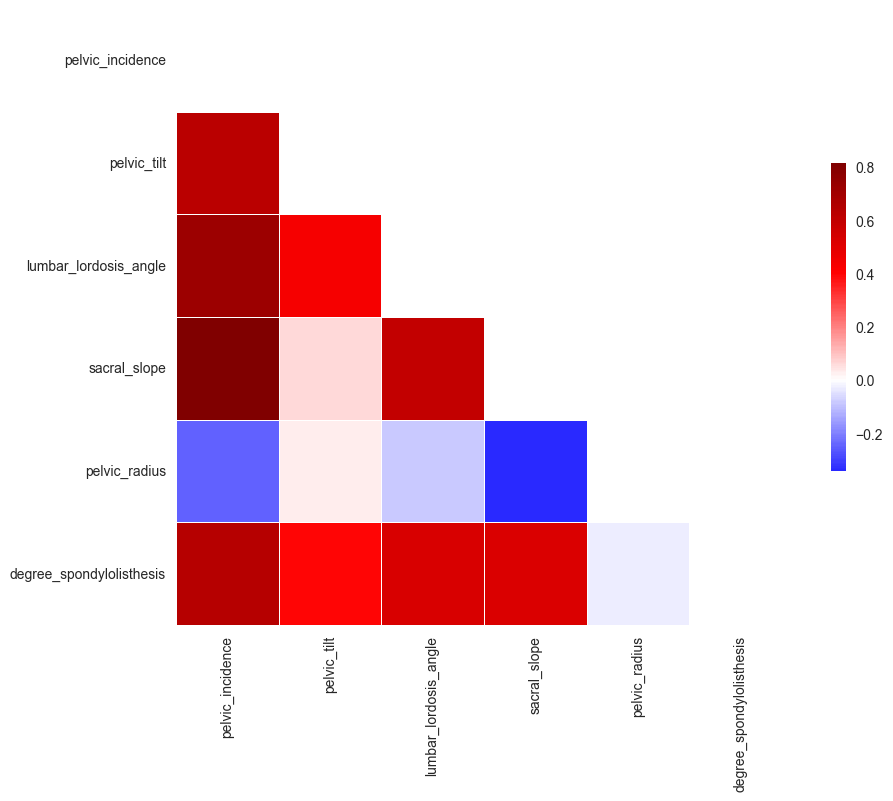

In [112]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

Vemos que menos el radio de la pelvis, que esta inversamente relacionado al resto, los otros parametros parecen tener una correlación alta. Podemos deducir que una columna no solo se desvia de una sola forma, cuando lo hace afecta a todos los parametros, también podemos decir que a menor radio de la pelvis, menores complicaciones.

In [113]:
print(df['class'].unique())
x = df['class']

['DH' 'SL' 'NO']


In [114]:
df['class'].value_counts()

SL    150
NO    100
DH     60
Name: class, dtype: int64

Vemos que como nos dice el enunciado la cantidad de personas en cada classe no esta balanceada, por lo que si no lo tenemos en cuenta el predictor puede tener un bias hacia las classes con mas objetos

In [115]:
classes = np.zeros(shape=x.size,dtype=int) ## NO es classe 0
for i in range(0,classes.size):
    if(x[i]=='DH'):classes[i] = 1; ## hernia discal es classe 1
    elif(x[i]=='SL'):classes[i] = 2; ## Spondylolisthesis es classe 2
labels = ['NO','DH','SL']


In [116]:
data = df.drop(columns=['class'])
#data = df.drop(columns=['class', 'degree_spondylolisthesis'])

In [117]:
X_train, X_test, y_train, y_test = train_test_split(data, classes, test_size=0.3, random_state=42)

In [118]:
scaler = MinMaxScaler();
X_train = scaler.fit_transform(X_train);
X_test = scaler.transform(X_test);

In [119]:
lr = LogisticRegression();
print('non fitted cross_val of lreg: ' + str(np.mean(cross_val_score(lr,X_train,y_train,cv=10))));


non fitted cross_val of lreg: 0.7419913419913421


Obtenemos una puntuacion bastante alta sin ajustar los parametros, seguramente debido al degree_spondylolisthesis, (sin este atributo nos sigue dando un resultado bastante razonable de ~0.70)

In [120]:
niter = 15
cv = 5
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,1001, endpoint=True)}

#usamos liblinear porque funciona mejor con datasets pequeños que los demas, segun la documentación, con class_weight en balanced
lreg = LogisticRegression(max_iter=1000,solver='liblinear',class_weight='balanced')
lr_bs =  BayesSearchCV(lreg,param,n_iter=niter,cv=cv, n_jobs=-1, refit=True, random_state=0)
lr_bs.fit(X_train,y_train);
show_html(pd.DataFrame(lr_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
10,"{'C': 345.1437393358564, 'penalty': 'l1'}",0.880,1
13,"{'C': 129.41958414499862, 'penalty': 'l1'}",0.880,1
6,"{'C': 633.8697112569276, 'penalty': 'l2'}",0.875,3
11,"{'C': 345.1437393358564, 'penalty': 'l2'}",0.875,3
5,"{'C': 106.6596121230259, 'penalty': 'l2'}",0.862,5


In [121]:
lr_ajustado = lr_bs.best_estimator_
lr_ajustado.fit(X_train,y_train);
print('fitted cross_val of lreg: ' + str(np.mean(cross_val_score(lr_ajustado,X_train,y_train,cv=10))))


fitted cross_val of lreg: 0.8714285714285716


validación cruzada mucho mejor

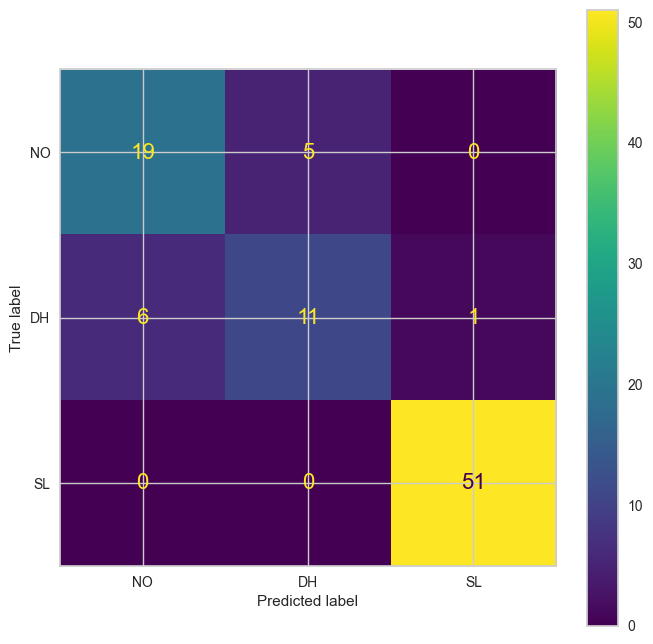

In [122]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_ajustado, X_test,y_test, ax=plt.subplot(),display_labels=labels);

en el test podemos ver lo que esperabamos, la classe SL se predice con un 99% de acierto, ya qye tenemos el degree_SL, y tambien parece distinguir bastante bien a los pacientes con la columna sana. Donde tiene mas dificultades es en diagnostico de DH.

In [123]:
print(classification_report(lr_ajustado.predict(X_test), y_test,target_names = labels));
results_df = save_results(lr_ajustado, X_test, y_test, 'Logistic Regression', results_df)

              precision    recall  f1-score   support

          NO       0.79      0.76      0.78        25
          DH       0.61      0.69      0.65        16
          SL       1.00      0.98      0.99        52

    accuracy                           0.87        93
   macro avg       0.80      0.81      0.80        93
weighted avg       0.88      0.87      0.87        93



El modelo parece tener el mismo acierto que con los datos de entrenamiento


---------------------------------------------------------------------------------------

<strong>
b) Ajusta una SVM para clasificación con kernel polinómico y RBF a los datos explorando
los hiperparámetros adecuadamente. Elige adecuadamente el modelo que parezca mejor y
compara sus resultados con el de regresión logística.


### Poly kernel


In [124]:
pca = PCA()

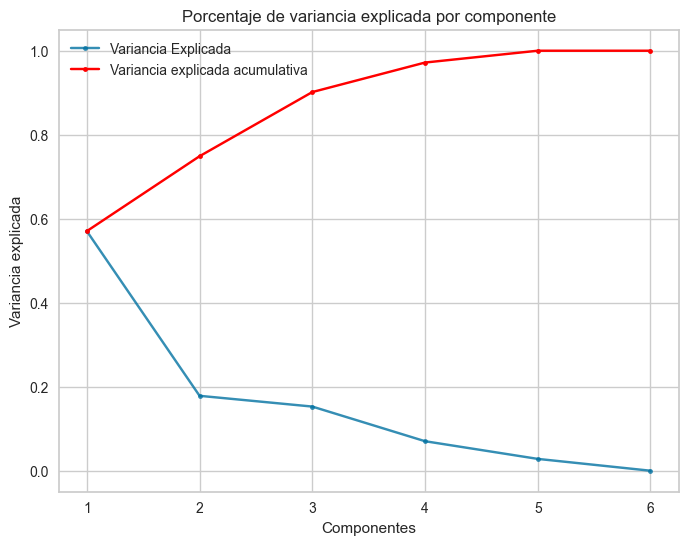

In [125]:
pca.fit(X_train)
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

dos componentes tienen el ~90% de la varianza

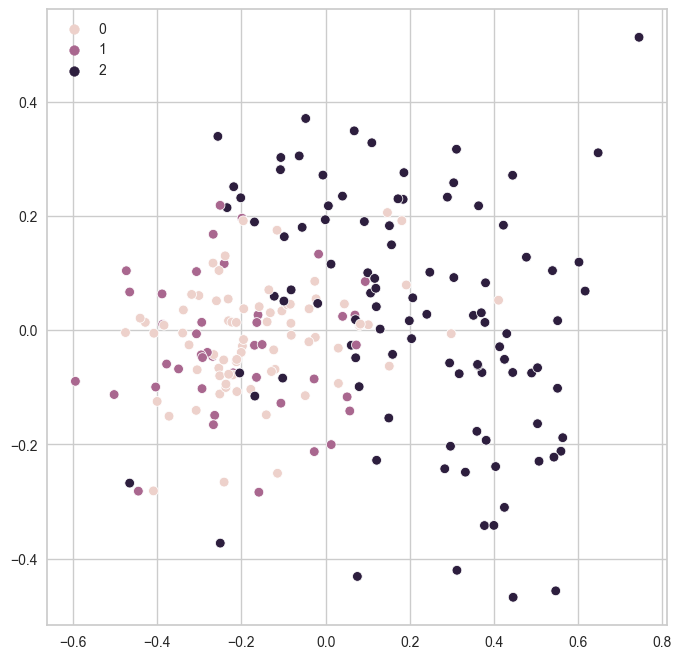

In [126]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
plt.figure(figsize=(8,8));
sns.scatterplot(x=X_train_pca[:,0], y=X_train_pca[:,1], hue=y_train);

Parece haber separabilidad entre NO/DH y SL (debida al degreeSL), pero no entre NO y DH

In [127]:
param = {'C':10**np.linspace(-3,3,101), 'degree':[2,3]}

psvc =  SVC(kernel='poly', max_iter=25000, random_state=0,class_weight='balanced')
psvc_gs = BayesSearchCV(psvc,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
psvc_gs.fit(X_train, y_train);
show_html(pd.DataFrame(psvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
10,"{'C': 36.3078054770101, 'degree': 2}",0.862,1
11,"{'C': 10.471285480508985, 'degree': 2}",0.862,2
14,"{'C': 1000.0, 'degree': 2}",0.857,3
12,"{'C': 165.95869074375597, 'degree': 2}",0.853,4
13,"{'C': 13.803842646028839, 'degree': 3}",0.843,5


In [128]:
svmPoly = psvc_gs.best_estimator_
svmPoly.fit(X_train,y_train);
print('fitted cross_val of svmPoly: ' + str(np.mean(cross_val_score(svmPoly,X_train,y_train,cv=10))))


fitted cross_val of svmPoly: 0.8755411255411257


Obtenemos resultados similares al anterior modelo en la validación cruzada, aunque ligeramtente peores

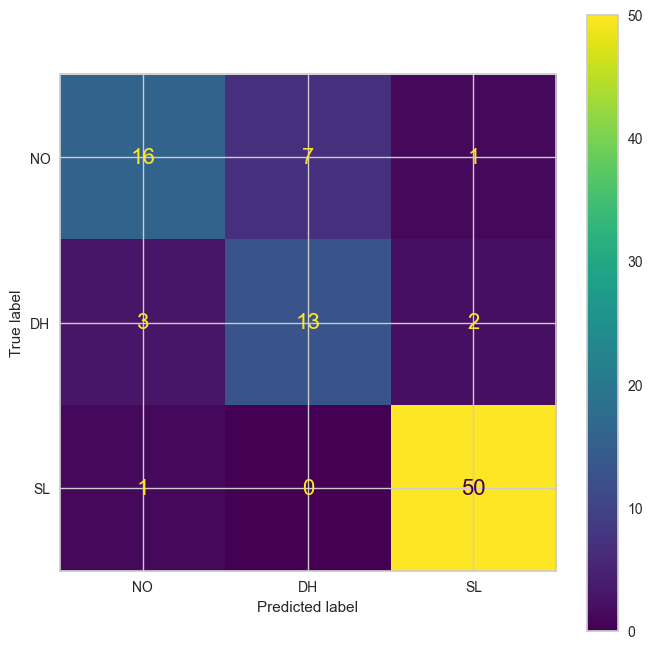

In [129]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(svmPoly, X_test,y_test, ax=plt.subplot(),display_labels=labels);

In [130]:
print(classification_report(svmPoly.predict(X_test), y_test,target_names = labels))
results_df = save_results(svmPoly, X_test, y_test, 'polynomial SVM', results_df)

              precision    recall  f1-score   support

          NO       0.67      0.80      0.73        20
          DH       0.72      0.65      0.68        20
          SL       0.98      0.94      0.96        53

    accuracy                           0.85        93
   macro avg       0.79      0.80      0.79        93
weighted avg       0.86      0.85      0.85        93



en este caso parece que le cuesta mas diferenciar entre DH y NO, y ademas el acierto del SL tambien ha bajado un poco

### RBF Kernel

In [131]:
param = {'C':10**np.linspace(-3,3,101), 'gamma':['scale','auto']}

rbsvc =  SVC(kernel='rbf', max_iter=25000, random_state=0,class_weight='balanced')
rbsvc_gs = BayesSearchCV(rbsvc,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
rbsvc_gs.fit(X_train, y_train);
show_html(pd.DataFrame(rbsvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
13,"{'C': 125.89254117941663, 'gamma': 'auto'}",0.862,1
10,"{'C': 331.13112148259074, 'gamma': 'auto'}",0.852,2
11,"{'C': 331.13112148259074, 'gamma': 'scale'}",0.843,3
14,"{'C': 125.89254117941663, 'gamma': 'scale'}",0.834,4
5,"{'C': 109.64781961431851, 'gamma': 'scale'}",0.834,5


In [132]:
svmRBF = rbsvc_gs.best_estimator_
svmRBF.fit(X_train,y_train);
print('fitted cross_val of svmRBF: ' + str(np.mean(cross_val_score(svmRBF,X_train,y_train,cv=10))))


fitted cross_val of svmRBF: 0.8571428571428571


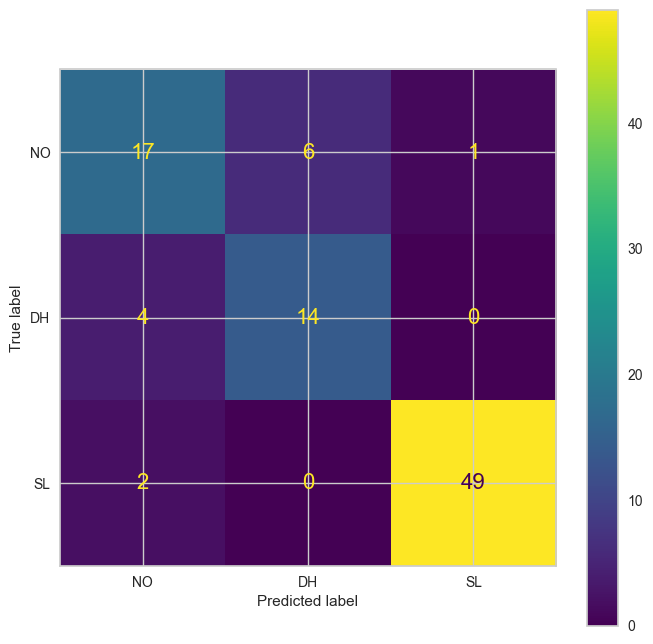

In [133]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(svmRBF, X_test,y_test, ax=plt.subplot(),display_labels=labels);

In [134]:
print(classification_report(svmRBF.predict(X_test), y_test,target_names = labels))
results_df = save_results(svmRBF, X_test, y_test, 'RBF SVM', results_df)

              precision    recall  f1-score   support

          NO       0.71      0.74      0.72        23
          DH       0.78      0.70      0.74        20
          SL       0.96      0.98      0.97        50

    accuracy                           0.86        93
   macro avg       0.82      0.81      0.81        93
weighted avg       0.86      0.86      0.86        93



Este modelo parece distinguir mejor que el anterior todas las classes, aunque siguie habiendo un poco de confusión entre no y DH

<strong> 
con el kernel RBF conseguimos hacer una mejor distinción de la classe DH a costa de un poco de precisión en las otras dos en comparación a la regressión logística




---------------------------------------------------------------------------------------

<strong>
c) Ajusta los modelos random forest y gradient boosting para clasificación explorando los hiperparámetros adecuadamente. Elige adecuadamente el modelo que parezca mejor y compara sus resultados con el de regresión logística y el mejor modelo del apartado anterior.


### Random Forest

In [135]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'criterion':['gini','entropy'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10]}

rf =  RandomForestClassifier(random_state=0,class_weight='balanced')
rf_bs =  BayesSearchCV(rf,param,n_iter=15, cv=5, n_jobs=-1, refit=True, random_state=0)
rf_bs.fit(X_train, y_train);

In [136]:
show_html(pd.DataFrame(rf_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
0,"{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 75}",0.843,1
6,"{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 10}",0.839,2
10,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 10}",0.839,2
14,"{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 75}",0.839,4
9,"{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 100}",0.838,5


In [137]:
ranForest = rf_bs.best_estimator_
ranForest.fit(X_train,y_train);
print('fitted cross_val of lreg: ' + str(np.mean(cross_val_score(ranForest,X_train,y_train,cv=10))))


fitted cross_val of lreg: 0.8619047619047621


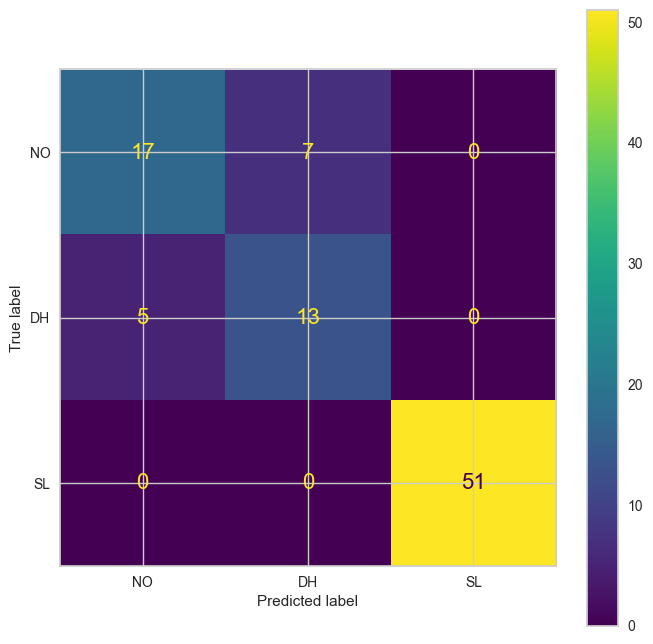

In [138]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(ranForest, X_test,y_test, ax=plt.subplot(),display_labels=labels);

In [139]:
print(classification_report(ranForest.predict(X_test), y_test,target_names = labels))
results_df = save_results(ranForest, X_test, y_test, 'Random Forest', results_df)

              precision    recall  f1-score   support

          NO       0.71      0.77      0.74        22
          DH       0.72      0.65      0.68        20
          SL       1.00      1.00      1.00        51

    accuracy                           0.87        93
   macro avg       0.81      0.81      0.81        93
weighted avg       0.87      0.87      0.87        93



Este modelo nos da un resultado similar a los anteriores, aunque cabe destacar que ha tenido un 100% de acierto en SL, tanto en precisión como en recall. Parece que tiene muy claro como separar SL del resto pero no DH de NO, que ya habiamos visto que tenian poca separabilidad

### Gradient Boosting


In [140]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'loss':['log_loss'], ##exponential no acepta mas de dos classes
         'criterion':['friedman_mse', 'squared_error'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10], 
         'learning_rate':[0.1,0.5, 1,3, 5, 10, 15]}

gb =  GradientBoostingClassifier(random_state=0,n_iter_no_change=5)
gb_bs =  BayesSearchCV(gb,param,n_iter=40, cv=10, n_jobs=-1, refit=True, random_state=0)
gb_bs.fit(X_train, y_train);

In [141]:
show_html(pd.DataFrame(gb_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
29,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 200}",0.830,1
35,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 9, 'min_samples_leaf': 10, 'n_estimators': 100}",0.830,1
21,"{'criterion': 'friedman_mse', 'learning_rate': 1.0, 'loss': 'log_loss', 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 75}",0.825,3
19,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'log_loss', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 25}",0.825,4
16,"{'criterion': 'squared_error', 'learning_rate': 0.5, 'loss': 'log_loss', 'max_depth': 1, 'min_samples_leaf': 10, 'n_estimators': 100}",0.825,4


In [142]:
gradBoosting = gb_bs.best_estimator_
gradBoosting.fit(X_train,y_train);
print('fitted cross_val of lreg: ' + str(np.mean(cross_val_score(gradBoosting,X_train,y_train,cv=10))))


fitted cross_val of lreg: 0.8296536796536798


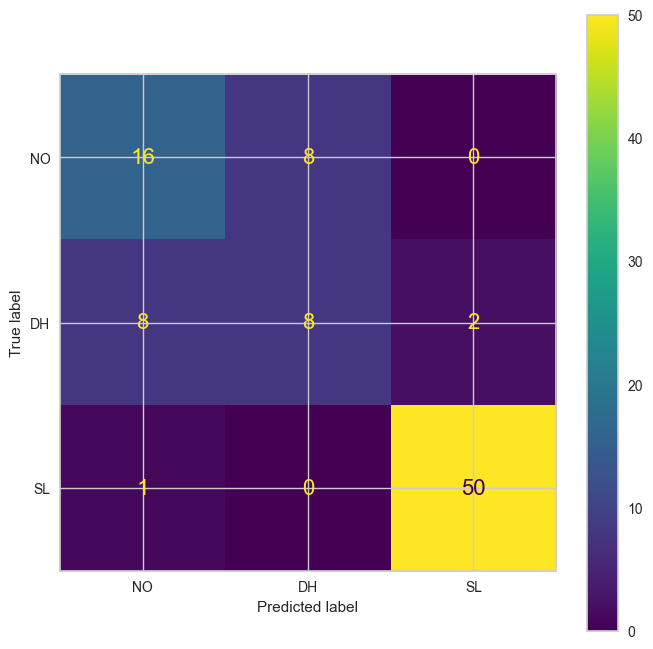

In [143]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gradBoosting, X_test,y_test, ax=plt.subplot(),display_labels=labels);

In [144]:
print(classification_report(gradBoosting.predict(X_test), y_test,target_names = labels))
results_df = save_results(gradBoosting, X_test, y_test, 'Gradient Boosting', results_df)

              precision    recall  f1-score   support

          NO       0.67      0.64      0.65        25
          DH       0.44      0.50      0.47        16
          SL       0.98      0.96      0.97        52

    accuracy                           0.80        93
   macro avg       0.70      0.70      0.70        93
weighted avg       0.80      0.80      0.80        93



Este parece ser el peor hasta ahora. Como el resto, la classe SL la distingue bastante bien, pero el NO y sobretodo el DH tienen mucha confusión.

-------------------------------------------------------------------------

<strong>
d) Como hemos visto en teoría, cuando tenemos varios modelos podemos combinarlos usando diferentes estrategias. Entrena un VotingClassifier usando el modelo regresión logística y los dos mejores modelos que has encontrado en los apartados anteriores con sus
mejores hiperparámetros. ¿Es mejor el modelo combinado?

In [145]:

results_df.sort_values(by=['test acc'], ascending=False)

,test acc,precision score (W),recall score (W),f1 score (W)
Logistic Regression,0.871,0.867,0.871,0.868
Random Forest,0.871,0.874,0.871,0.872
RBF SVM,0.860,0.864,0.860,0.861
polynomial SVM,0.849,0.850,0.849,0.847
Gradient Boosting,0.796,0.789,0.796,0.792


Vamos a unsar la logistic Regression, que tiene la mayor score de todas, RBF SVM, que se puede apreciar en su matriz de confusión que distingue bastante bien NO y DH; y por ultimo Random Forest, que tiene un 1 en accuracy de SL

In [146]:
vs = VotingClassifier([('lr', lr_bs.best_estimator_),
                        ('rbf', rbsvc_gs.best_estimator_),
                        ('rf',rf_bs.best_estimator_)],voting='hard', n_jobs=1)
print(np.mean(cross_val_score(vs,X_train,y_train,cv=5)))                             
vs.fit(X_train, y_train); 

0.8847780126849895


In [147]:
print(classification_report(vs.predict(X_test), y_test,target_names=labels))
results_df = save_results(vs, X_test, y_test, 'Voting LR+RBF+RF', results_df)

              precision    recall  f1-score   support

          NO       0.79      0.86      0.83        22
          DH       0.83      0.75      0.79        20
          SL       1.00      1.00      1.00        51

    accuracy                           0.91        93
   macro avg       0.88      0.87      0.87        93
weighted avg       0.91      0.91      0.91        93



In [148]:
results_df.sort_values(by=['test acc'], ascending=False)

,test acc,precision score (W),recall score (W),f1 score (W)
Voting LR+RBF+RF,0.914,0.916,0.914,0.914
Logistic Regression,0.871,0.867,0.871,0.868
Random Forest,0.871,0.874,0.871,0.872
RBF SVM,0.860,0.864,0.860,0.861
polynomial SVM,0.849,0.850,0.849,0.847
Gradient Boosting,0.796,0.789,0.796,0.792


Parece que en este caso el mejor modelo es el que resulta de combinar los tres mencionados anteriormente. Esto seguramente se deba a que cada uno de los modelos dan resultados algo distintos y cada uno hace bien una cosa distinta.